## Credit: Time Series Forecasting in Python book by Marco Peixeiro published by Manning

Re-wrote author's original code to leverage pandas datetime index filtering and improved chart aesthetics.  Original code was very numpy array-centric and relied on integer indexing, whereas using date range would have been more convenient.

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

#### Load sample data set

Total number of monthly passengers for an airline. The data was recorded from January 1949 to December 1960.

In [2]:
df = pd.read_csv('../data/air-passengers.csv', parse_dates=['Month']).set_index('Month')
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### Let's visualize the data

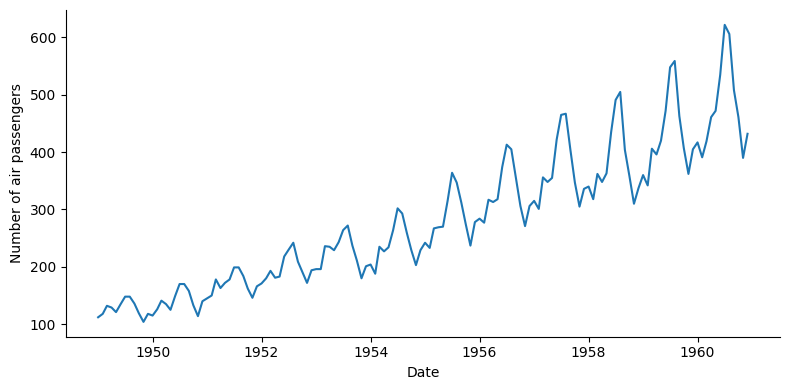

In [3]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df.index, df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.show()

Observing the chart, we know that this is monthly data, which means that m = 12. Also, we can see that the months of July and August usually have the highest numbers of air passengers in the year, as shown by the round markers in the plot below. Therefore, if we are to forecast the month of July in 1961, the information coming from the month of July in prior years is likely going to be useful, since we can intuitively expect the number of air passengers to be at its highest point in the month of July 1961. The parameters P, D, Q, and m allow us to capture that information from the previous seasonal cycle to help us forecast our time series.

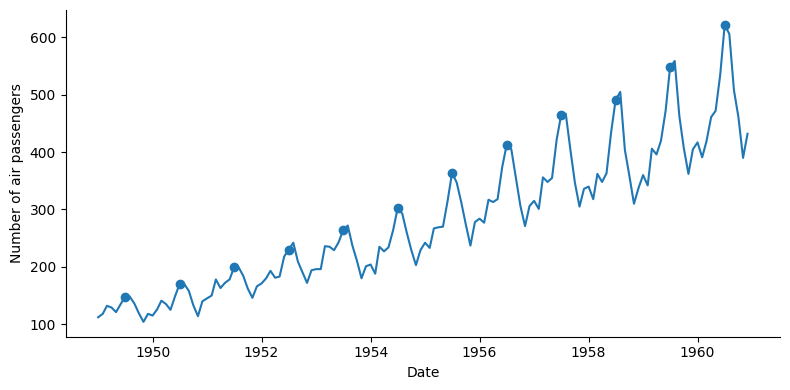

In [38]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df.index, df['Passengers'], markevery=np.arange(6, 145, 12), marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.show()

Looking at the total monthly air passengers in the plot below, it is easy for us to identify a repeating pattern every year, with a high number of passengers being recorded during June, July, and August of each year, and fewer passengers in November, December, and January of each year.

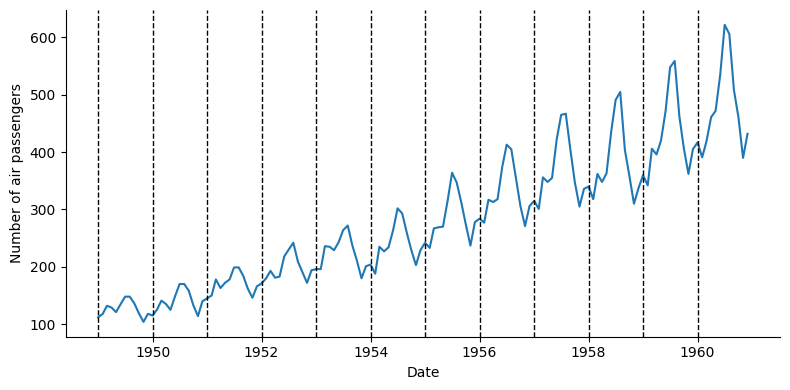

In [5]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df.index, df['Passengers'])
for i in df.index[::12]:
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.show()

## Time Series Decomposition

Time series decomposition is a statistical task that separates the time series into its three main components:
- a trend component
- a seasonal component
- and the residuals

The trend component represents the long-term change in the time series. This component is responsible for time series that increase or decrease over time. The seasonal component is, of course, the seasonal pattern in the time series. It represents repeated fluctuations that occur over a fixed period of time. Finally, the residuals, or the noise, express any irregularity that cannot be explained by the trend or the seasonal component.

With time series decomposition, we can clearly identify and visualize the seasonal component of a time series. We can decompose the dataset for air passengers using the `STL` function from the statsmodels library to generate the plot for each component.

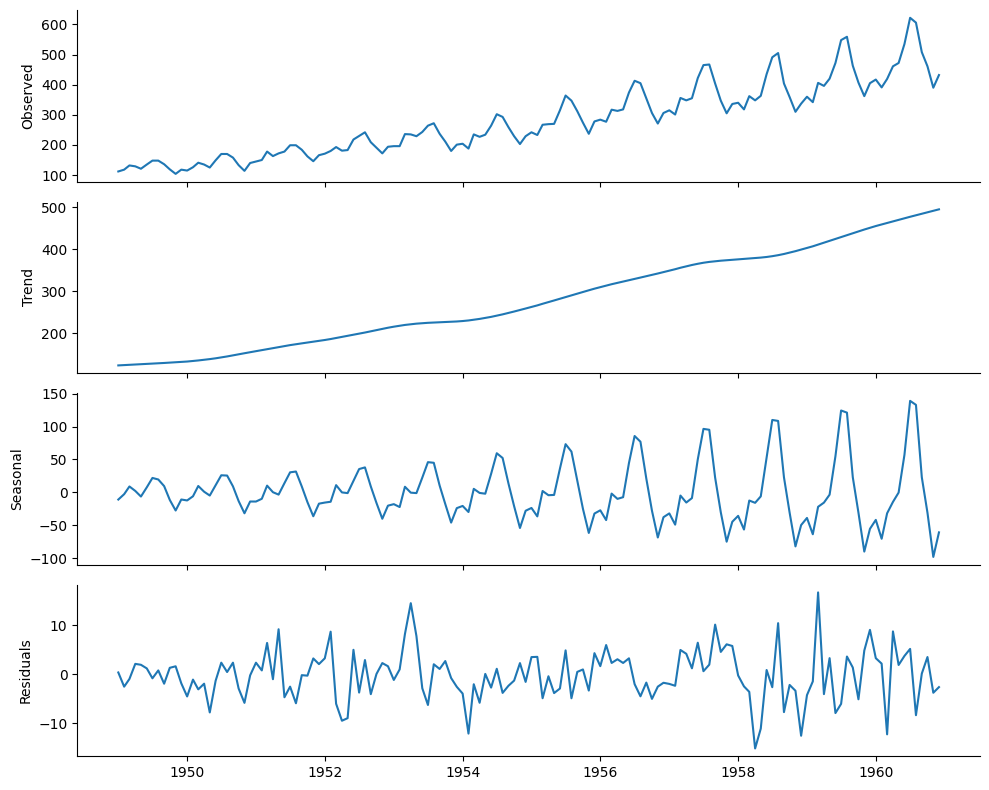

In [6]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

for ax in [ax1, ax2, ax3, ax4]:
    ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.show()

## Testing for Stationarity with Augmented Dickey-Fuller Test

In [7]:
ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060352
p-value: 0.9918802434376408


## Achieving Stationarity for the ARIMA Model

#### 1st-Order Differencing

In [8]:
df = df.assign(diff=df['Passengers'].diff(1))

In [9]:
df.head()

,Passengers,diff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [10]:
ad_fuller_result = adfuller(df['diff'].dropna())

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241699945
p-value: 0.05421329028382621


#### 2nd-Order Differencing - Stationarity Achieved (`d` = 2)

In [11]:
df = df.assign(diff2=df['diff'].diff(1))

In [12]:
df.head()

,Passengers,diff,diff2
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


In [13]:
ad_fuller_result = adfuller(df['diff2'].dropna())

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.38423154246852
p-value: 2.732891850014085e-29


Since we differenced twice, our `d` parameter will be equal to 2 for the ARIMA model.  Now that we established what our `d` parameter will be, we can now pursue running the model against all the combinations for the `p` and `q` parameters with a custom function.

#### Custom function to obtain optimal SARIMA parameters

In [14]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

Finding the best ARIMA parameters.  Note: We set P, D, and Q to 0 because a SARIMA(p,d,q)(0,0,0)m model is equivalent to an ARIMA(p,d,q) model.

In [15]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]                  # Set to zero since we are looking to optimize for ARIMA model, not SARIMA model
Qs = [0]                  # Set to zero since we are looking to optimize for ARIMA model, not SARIMA model

d = 2
D = 0                     # Set to zero since we are looking to optimize for ARIMA model, not SARIMA model
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

# train = df['Passengers'][:-12]
train = df['1949':'1959']['Passengers']

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.890750
1,"(11, 4, 0, 0)",1019.035122
2,"(11, 5, 0, 0)",1020.465125
3,"(11, 1, 0, 0)",1021.027139
4,"(11, 7, 0, 0)",1021.662838
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


For our ARIMA model, the optimal parameters are (p=11, d=2, q=3)

#### ARIMA(p=11, d=2, q=3) Model Summary

In [16]:
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  132
Model:              SARIMAX(11, 2, 3)   Log Likelihood                -493.445
Date:                Tue, 03 Oct 2023   AIC                           1016.891
Time:                        20:45:20   BIC                           1059.904
Sample:                    01-01-1949   HQIC                          1034.368
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8259      0.100     -8.286      0.000      -1.021      -0.631
ar.L2         -0.9638      0.049    -19.651      0.000      -1.060      -0.868
ar.L3         -0.8515      0.087     -9.768      0.0

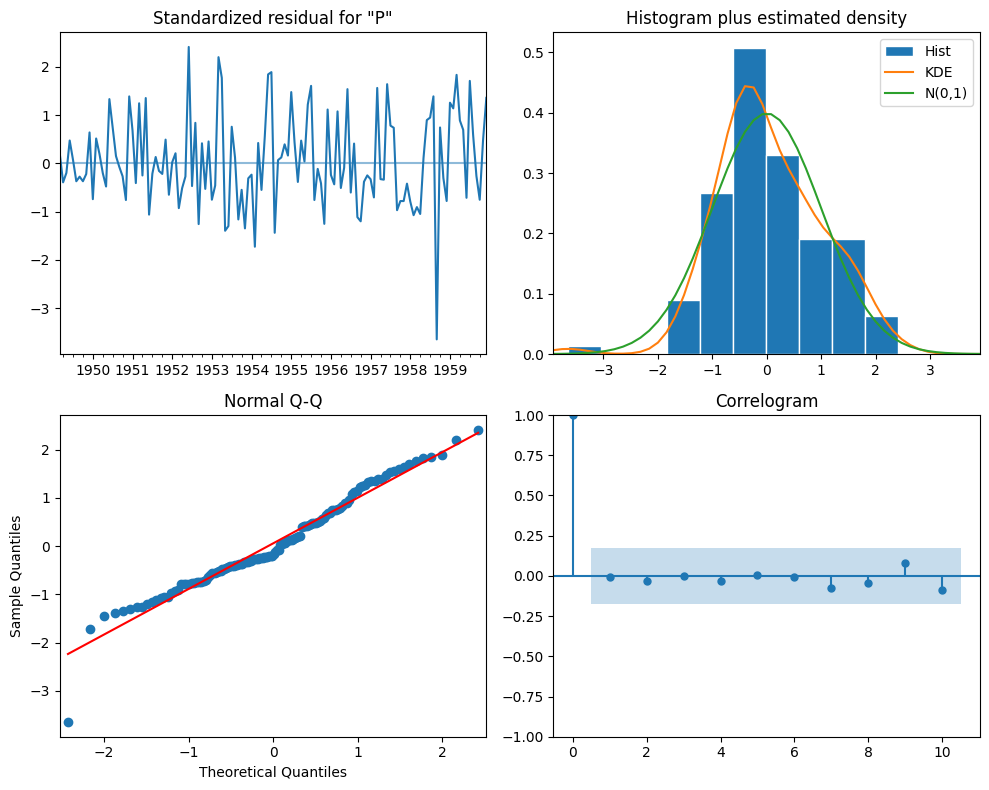

In [17]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

In the top-left plot, the residuals have no trend with a variance that seems fairly constant over time, which resembles the behavior of white noise. The top-right plot shows the distribution of the residuals, which approaches a normal distribution, despite the unusual peak. This is further confirmed by the Q-Q plot at the bottom left, which displays a fairly straight line that lies on y = x. Finally, the correlogram in the bottom-right plot shows no significant autocorrelation coefficients after lag 0, which is exactly like white noise. From this analysis, the residuals resemble white noise.

#### Ljung-Box Test (we want all p-values > 0.05)

The next step is to run the Ljung-Box test on the residuals to make sure that they are independent and uncorrelated.

In [18]:
residuals = ARIMA_model_fit.resid

lungbox_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lungbox_df

,lb_stat,lb_pvalue
1,6.580342,0.010311
2,6.710784,0.034896
3,6.959364,0.073204
4,7.786726,0.099711
5,8.415651,0.134767
6,8.740414,0.188712
7,9.611334,0.211689
8,9.838773,0.276525
9,9.849403,0.362814
10,11.663828,0.308185


The returned p-values are all greater than 0.05 except for the first two values. This means that, according to the Ljung-Box test, we reject the null hypothesis with a 5%
chance of being wrong, since we set our significance boundary to 0.05. However, the third value and onwards are all greater than 0.05, so we reject the null hypothesis, concluding that the residuals are uncorrelated starting at lag 3.

This is an interesting situation to dissect, because the graphical analysis of the residuals leads us to conclude that they resemble white noise, but the Ljung-Box test points to some correlation at lags 1 and 2. This means that our ARIMA model is not capturing all the information from the data.

In this case, we’ll move forward with the model, because we know that we are modeling seasonal data with a non-seasonal model. Therefore, the Ljung-Box test is really telling us that our model is not perfect, but that’s okay, because part of this exercise is to compare the performance of ARIMA and SARIMA and demonstrate that SARIMA is the way to go when dealing with seasonal data.

As previously mentioned, we wish to predict a full year of monthly air passengers, using the last 12 months of data as our test set. The baseline model is the naive seasonal forecast, where we simply use the number of air passengers for each month of 1959 as a forecast for each month of 1960.

We're going to create our test data set to be the last year's worth of our original data (1960):

In [19]:
test = df['1960-01':'1960-12']  # or we could do df.iloc[-12:]
test

,Passengers,diff,diff2
Month,,,
1960-01-01,417,12.0,-31.0
1960-02-01,391,-26.0,-38.0
1960-03-01,419,28.0,54.0
1960-04-01,461,42.0,14.0
1960-05-01,472,11.0,-31.0
1960-06-01,535,63.0,52.0
1960-07-01,622,87.0,24.0
1960-08-01,606,-16.0,-103.0
1960-09-01,508,-98.0,-82.0


In [20]:
test = test.assign(naive_seasonal=df['1959-01-01':'1959-12-31']['Passengers'].values)
test

,Passengers,diff,diff2,naive_seasonal
Month,,,,
1960-01-01,417,12.0,-31.0,360
1960-02-01,391,-26.0,-38.0,342
1960-03-01,419,28.0,54.0,406
1960-04-01,461,42.0,14.0,396
1960-05-01,472,11.0,-31.0,420
1960-06-01,535,63.0,52.0,472
1960-07-01,622,87.0,24.0,548
1960-08-01,606,-16.0,-103.0,559
1960-09-01,508,-98.0,-82.0,463


In [21]:
ARIMA_pred = ARIMA_model_fit.get_prediction(start='1960-01-01', end='1960-12-01').predicted_mean

# Assign the forecasts to the ARIMA_pred column
test = test.assign(ARIMA_pred=ARIMA_pred.values)
test

,Passengers,diff,diff2,naive_seasonal,ARIMA_pred
Month,,,,,
1960-01-01,417,12.0,-31.0,360,422.288587
1960-02-01,391,-26.0,-38.0,342,410.332218
1960-03-01,419,28.0,54.0,406,461.428614
1960-04-01,461,42.0,14.0,396,457.156875
1960-05-01,472,11.0,-31.0,420,481.277206
1960-06-01,535,63.0,52.0,472,530.857382
1960-07-01,622,87.0,24.0,548,605.936664
1960-08-01,606,-16.0,-103.0,559,615.214999
1960-09-01,508,-98.0,-82.0,463,525.259655


## Achieving Stationarity for the SARIMA Model

In the previous section, we used an ARIMA(11,2,3) model to forecast the number of monthly air passengers. Now we’ll fit a SARIMA model and see if it performs better than the ARIMA model. Hopefully the SARIMA model will perform better, since it can capture seasonal information, and we know that our dataset exhibits clear seasonality as can be seen in the plot below.

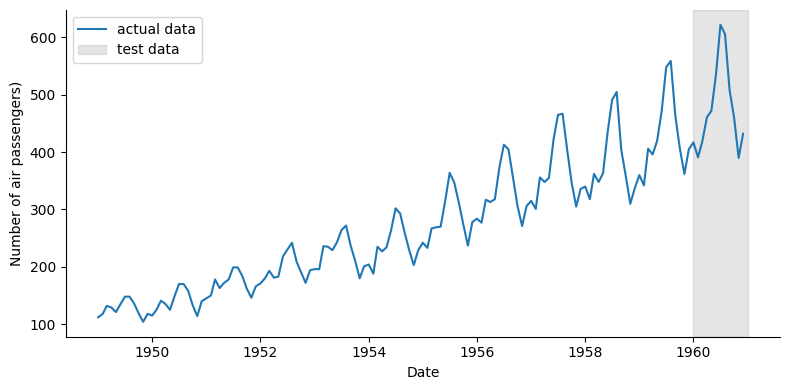

In [22]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df.index, df['Passengers'], label='actual data')
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers)')
ax.axvspan('1960-01-01', '1960-12-31', color='#808080', alpha=0.2, label='test data')
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#### Testing for Stationarity with Augmented Dickey-Fuller Test

In [23]:
ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060352
p-value: 0.9918802434376408


#### 1st-Order Differencing

In [24]:
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241699945
p-value: 0.05421329028382621


#### 1st-Order Seasonal Differencing - Stationarity Achieved (`D` = 1)

In [25]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.624862360087867
p-value: 3.823046856301727e-30


We achieved stationarity after performing 1st-order differencing (`d`=1) and performing 1st-order seasonal differencing (`D`=1).

With this step done, we can now define the range of possible values for p, q, P, and Q, fit each unique SARIMA(p,d,q)(P,D,Q)m model, and select the one with the lowest AIC.

Again, we will use our custom `optimize_SARIMA()` function.  This may take a while...

In [26]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

# train = df['Passengers'][:-12]
train = df['1949':'1959']['Passengers']

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.247486
1,"(2, 1, 2, 1)",893.700870
2,"(2, 1, 1, 3)",894.094415
3,"(1, 0, 1, 2)",894.289167
4,"(0, 1, 1, 2)",894.993390
...,...,...
249,"(0, 0, 2, 0)",906.940147
250,"(3, 2, 0, 3)",907.181875
251,"(0, 0, 3, 2)",907.453191
252,"(0, 0, 3, 0)",908.742583


Once the function is done running, we find that the SARIMA(2,1,1)(1,1,2) 12 model has the lowest AIC, which is a value of 892.24. We can fit this model again on the training set to perform residual analysis.

In [27]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -439.124
Date:                                 Tue, 03 Oct 2023   AIC                            892.247
Time:                                         21:06:48   BIC                            911.701
Sample:                                     01-01-1949   HQIC                           900.147
                                          - 12-01-1959                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2665      0.085    -14.986      0.000      -1.432      -1

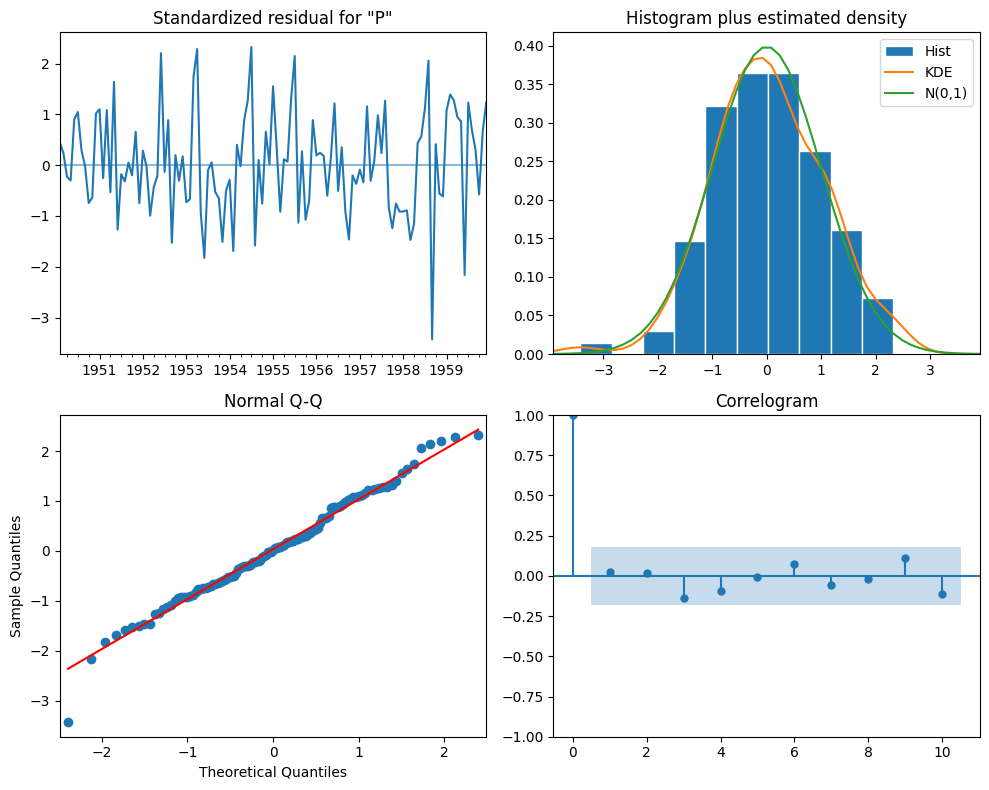

In [28]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

In [29]:
residuals = SARIMA_model_fit.resid

lungbox_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lungbox_df

,lb_stat,lb_pvalue
1,0.004796,0.944789
2,0.749354,0.687511
3,1.027810,0.794523
4,1.229761,0.873175
5,1.438844,0.920017
6,1.714483,0.943998
7,2.311550,0.940607
8,2.718013,0.950789
9,2.734184,0.973909
10,4.963521,0.893601


The returned p-values are all greater than 0.05. Therefore, we do not reject the null hypothesis, and we conclude that the residuals are independent and uncorrelated, just like white noise.

Our model has passed all the tests from the residuals analysis, and we are ready to use it for forecasting. Again, we’ll forecast the number of monthly air passengers for the year of 1960 to compare the predicted values to the observed values in the test set.

In [30]:
SARIMA_pred = SARIMA_model_fit.get_prediction(start='1960-01-01', end='1960-12-01').predicted_mean

# Assign the forecasts to the ARIMA_pred column
test = test.assign(SARIMA_pred=SARIMA_pred.values)
test

,Passengers,diff,diff2,naive_seasonal,ARIMA_pred,SARIMA_pred
Month,,,,,,
1960-01-01,417,12.0,-31.0,360,422.288587,418.523062
1960-02-01,391,-26.0,-38.0,342,410.332218,399.617510
1960-03-01,419,28.0,54.0,406,461.428614,461.353533
1960-04-01,461,42.0,14.0,396,457.156875,451.488749
1960-05-01,472,11.0,-31.0,420,481.277206,473.811810
1960-06-01,535,63.0,52.0,472,530.857382,538.794003
1960-07-01,622,87.0,24.0,548,605.936664,612.512654
1960-08-01,606,-16.0,-103.0,559,615.214999,624.719991
1960-09-01,508,-98.0,-82.0,463,525.259655,520.231212


Now that we have the results, we can compare the performance of each model and determine the best forecasting method for our problem.

We can now compare the performance of each forecasting method: the naive seasonal forecasts, the ARIMA model, and the SARIMA model. We’ll use the mean absolute percentage error (MAPE) to evaluate each model. We can first visualize the forecasts against the observed values of the test set.

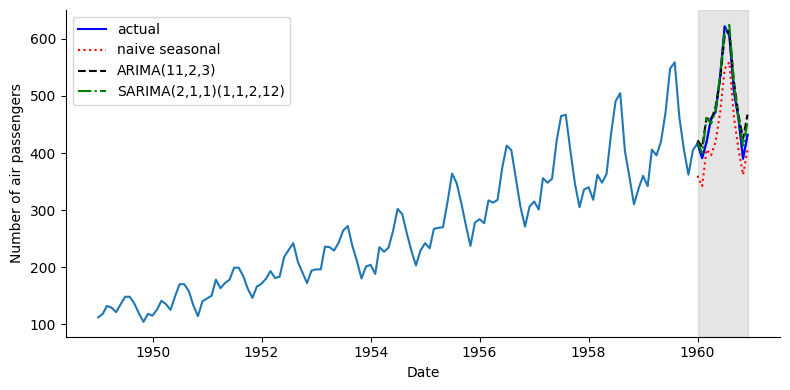

In [31]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df.index, df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan('1960-01', '1960-12-01', color='#808080', alpha=0.2)

ax.legend(loc='upper left')

ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.show()

Same plot as above, but displaying last 2 years' worth of data to provide a more zoomed view.

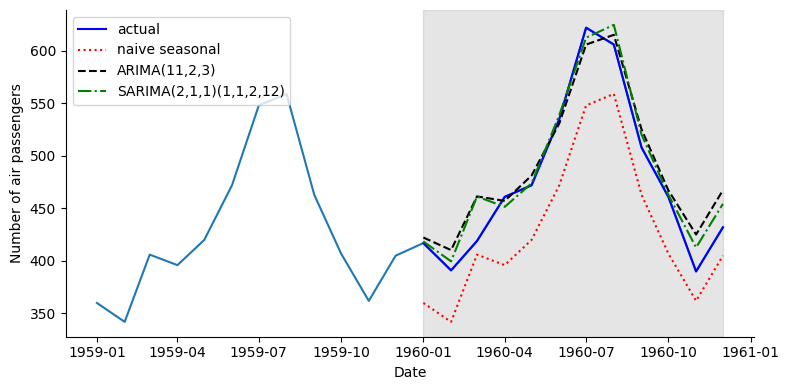

In [32]:
fig, ax = plt.subplots(figsize=(8,4))

# ax.plot(df['1975':'1980'].index, df['1975':'1980']['data'])
ax.plot(df['1959-01':'1960-12'].index, df['1959-01':'1960-12']['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan('1960-01', '1960-12-01', color='#808080', alpha=0.2)

ax.legend(loc='upper left')

ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.show()

In [33]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

9.987532920823485 3.829263964521771 2.8571747786046435


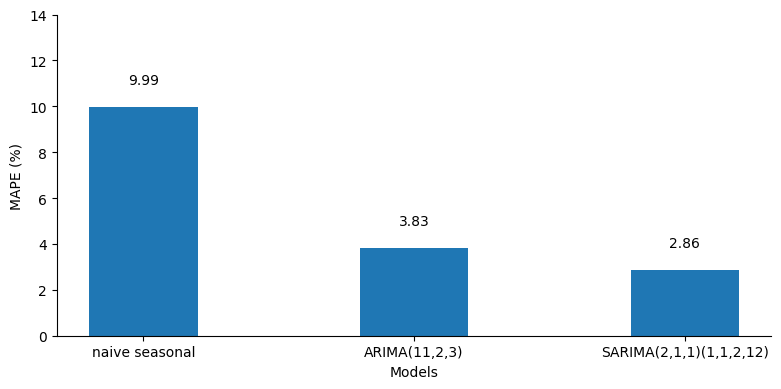

In [35]:
fig, ax = plt.subplots(figsize=(8,4))

x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 14)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.show()

Our baseline achieves a MAPE of 9.99%. The ARIMA model produced forecasts with a MAPE of 3.83%, and the SARIMA model scored a MAPE of 2.86%. A MAPE closer to 0 is indicative of better predictions, so the SARIMA model is the best-performing method for this situation. This makes sense, since our dataset had clear seasonality, and the SARIMA model is built to use the seasonal properties of time series to make forecasts.